In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

In [2]:
train_dir = "../data/training"
test_dir = "../data/testing"
labels = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]
image_size = 150

In [3]:
def count_images(directory):
    counts = {}
    for label in labels:
        folder_path = os.path.join(directory, label)
        counts[label] = len(os.listdir(folder_path))
    return counts

train_counts = count_images(train_dir)
test_counts = count_images(test_dir)

print("Quantidade de imagens no conjunto de treinamento:")
print(train_counts)
print("\nQuantidade de imagens no conjunto de teste:")
print(test_counts)

Quantidade de imagens no conjunto de treinamento:
{'glioma_tumor': 826, 'meningioma_tumor': 822, 'no_tumor': 395, 'pituitary_tumor': 827}

Quantidade de imagens no conjunto de teste:
{'glioma_tumor': 100, 'meningioma_tumor': 115, 'no_tumor': 105, 'pituitary_tumor': 74}


In [4]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

X = []
y = []

In [5]:
for label in labels:
    folder_path = os.path.join(train_dir, label)
    for img_name in tqdm(os.listdir(folder_path)):
        img = cv2.imread(os.path.join(folder_path, img_name))
        img = cv2.resize(img, (image_size, image_size))
        X.append(img)
        y.append(label)
    
    folder_path = os.path.join(test_dir, label)
    for img_name in tqdm(os.listdir(folder_path)):
        img = cv2.imread(os.path.join(folder_path, img_name))
        img = cv2.resize(img, (image_size, image_size))
        X.append(img)
        y.append(label)

100%|██████████| 74/74 [00:00<00:00, 105.33it/s]


In [6]:
X = np.array(X) / 255.0 
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y, num_classes=len(labels))

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [8]:
class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [16]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(150, 150, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

c:\Users\David Cumaru\Desktop\Brain_Tumor\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

In [12]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    validation_data=(X_val, y_val),
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 70s 820ms/step - accuracy: 0.4967 - loss: 5.5869 - val_accuracy: 0.1531 - val_loss: 9.6346 - learning_rate: 0.0010
Epoch 2/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 74s 907ms/step - accuracy: 0.6727 - loss: 0.8810 - val_accuracy: 0.1639 - val_loss: 9.2265 - learning_rate: 0.0010
Epoch 3/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 75s 913ms/step - accuracy: 0.7202 - loss: 0.6919 - val_accuracy: 0.2144 - val_loss: 3.9004 - learning_rate: 0.0010
Epoch 4/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 75s 912ms/step - accuracy: 0.7501 - loss: 0.5632 - val_accuracy: 0.2129 - val_loss: 2.9713 - learning_rate: 0.0010
Epoch 5/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 76s 929ms/step - accuracy: 0.7845 - loss: 0.5291 - val_accuracy: 0.5957 - val_loss: 1.5553 - learning_rate: 0.0010
Epoch 6/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 74s 907ms/step - accuracy: 0.8241 - loss: 0.4226 - val_accuracy: 0.6478 - val_loss: 1.2874 - learning_rate: 0.0010
Epoch 7/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 72s 874ms/step - accuracy: 0.8303 - loss: 0.

In [13]:
loss, acc = model.evaluate(X_val, y_val)
print(f'Loss: {loss:.4f}, Accuracy: {acc:.4f}')

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.9105 - loss: 0.2580
Loss: 0.2435, Accuracy: 0.9234


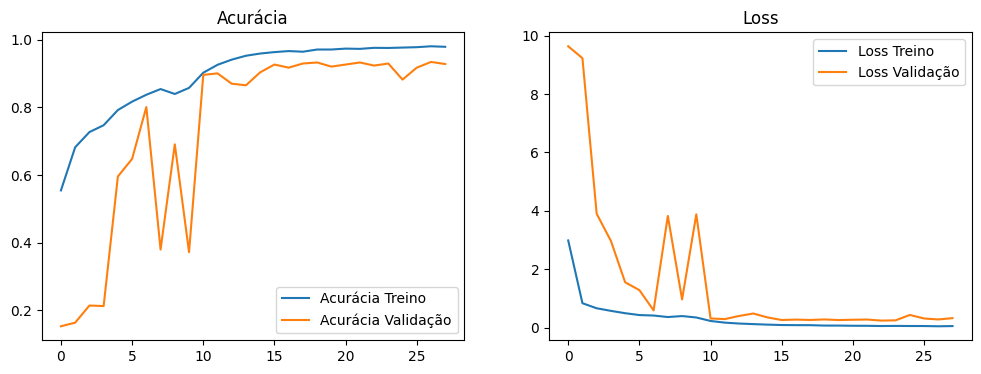

In [14]:
def plot_learning_curves(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Acurácia Treino')
    plt.plot(history.history['val_accuracy'], label='Acurácia Validação')
    plt.legend()
    plt.title('Acurácia')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss Treino')
    plt.plot(history.history['val_loss'], label='Loss Validação')
    plt.legend()
    plt.title('Loss')
    plt.show()

plot_learning_curves(history)

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step


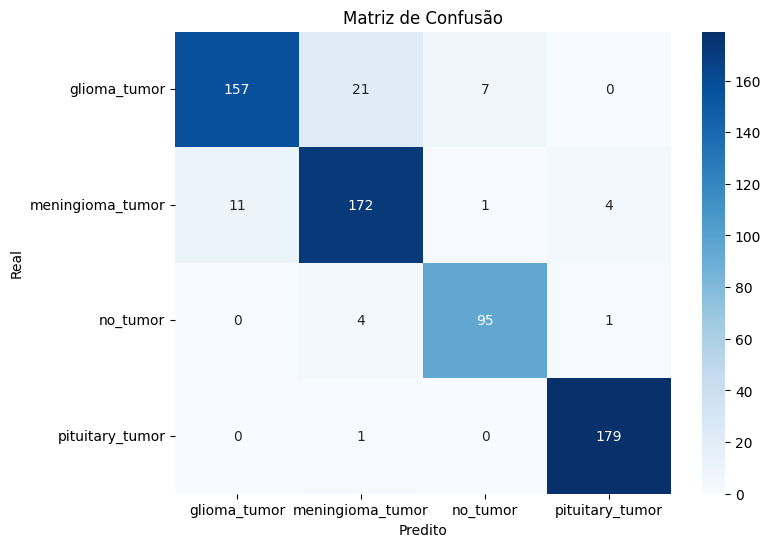

                  precision    recall  f1-score   support

    glioma_tumor       0.93      0.85      0.89       185
meningioma_tumor       0.87      0.91      0.89       188
        no_tumor       0.92      0.95      0.94       100
 pituitary_tumor       0.97      0.99      0.98       180

        accuracy                           0.92       653
       macro avg       0.92      0.93      0.93       653
    weighted avg       0.92      0.92      0.92       653



In [15]:
y_pred = np.argmax(model.predict(X_val), axis=1)
y_true = np.argmax(y_val, axis=1)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()
print(classification_report(y_true, y_pred, target_names=labels))